In [2]:
# Import libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# 1. Tree-Based Methods

## (a) 
Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks. The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [2]:
# Load dataset
APS_train_raw = pd.read_csv("../data/aps_failure_training_set.csv", skiprows=20, na_values='na')
display(APS_train_raw)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,neg,153002,NaN,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,neg,2286,NaN,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,neg,112,0.0,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,neg,80292,NaN,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [3]:
APS_test_raw = pd.read_csv("../data/aps_failure_test_set.csv", skiprows=20, na_values='na')
display(APS_test_raw)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0.0,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,neg,82,0.0,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,neg,66002,2.0,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,neg,59816,NaN,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,neg,1814,NaN,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,neg,81852,NaN,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,neg,18,0.0,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,neg,79636,NaN,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,neg,110,NaN,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


## (b) Data Preparation
This data set has *missing values*. When the number of data with missing values is significant, discarding them is not a good idea.

### i. 
Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

In [4]:
print(APS_train_raw.isnull().sum())

class         0
aa_000        0
ab_000    46329
ac_000     3335
ad_000    14861
          ...  
ee_007      671
ee_008      671
ee_009      671
ef_000     2724
eg_000     2723
Length: 171, dtype: int64


In [5]:
print(APS_test_raw.isnull().sum())

class         0
aa_000        0
ab_000    12363
ac_000      926
ad_000     3981
          ...  
ee_007      192
ee_008      192
ee_009      192
ef_000      762
eg_000      762
Length: 171, dtype: int64


From the summary above, we see that the class column in both dataset does not contain missing values. Therefore, we choose to impute the dataframe without the class column.

In [6]:
# Use SimpleImputer to fill missing values
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fill missing value for training data (numerical only)
APS_train_imp = imp_mean.fit_transform(APS_train_raw.iloc[:, 1:])
APS_train_imp = pd.DataFrame(APS_train_imp)

# Fill missing value for testing data (numerical only)
APS_test_imp = imp_mean.fit_transform(APS_test_raw.iloc[:, 1:])
APS_test_imp = pd.DataFrame(APS_test_imp)

In [7]:
# Concatenate dataframes
APS_train = pd.concat([APS_train_raw.iloc[:, :1], APS_train_imp], axis=1)
APS_train.columns = APS_train_raw.columns
display(APS_train)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698.0,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058.0,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040.0,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874.0,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,neg,153002.0,0.713189,6.640000e+02,186.000000,0.0,0.0,0.0,0.0,0.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,neg,2286.0,0.713189,2.130707e+09,224.000000,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,neg,112.0,0.000000,2.130706e+09,18.000000,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,neg,80292.0,0.713189,2.130706e+09,494.000000,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [8]:
# Concatenate dataframes
APS_test = pd.concat([APS_test_raw.iloc[:, :1], APS_test_imp], axis=1)
APS_test.columns = APS_test_raw.columns
display(APS_test)

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60.0,0.000000,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,neg,82.0,0.000000,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,neg,66002.0,2.000000,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,neg,59816.0,0.772065,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,neg,1814.0,0.772065,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,neg,81852.0,0.772065,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,neg,18.0,0.000000,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,neg,79636.0,0.772065,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,neg,110.0,0.772065,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


From the instruction on Piazza, we are expected to use the entire dataset for part ii, iii, iv, and v. Thus, let's concatenate them into one dataframe.

In [9]:
APS_all = pd.concat([APS_train, APS_test])
APS_all

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698.0,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058.0,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040.0,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874.0,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,neg,81852.0,0.772065,2.130706e+09,892.000000,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,neg,18.0,0.000000,5.200000e+01,46.000000,8.0,26.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,neg,79636.0,0.772065,1.670000e+03,1518.000000,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,neg,110.0,0.772065,3.600000e+01,32.000000,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


### ii.
For each of the 170 features, calculate the coefficient of variation $CV = \frac{s}{m}$, where $s$ is sample standard deviation and $m$ is sample mean.

In [10]:
# Define function to calculate cv
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100
# Apply to dataframe and display result
APS_cv = pd.DataFrame(APS_all.iloc[:, 1:].apply(cv), columns=['CV'])
display(APS_cv)

,CV
aa_000,432.860784
ab_000,217.839732
ac_000,216.764841
ad_000,20678.680935
ae_000,2229.399814
...,...
ee_007,488.508596
ee_008,333.501896
ee_009,575.391710
ef_000,4792.513454


### iii. 
Plot a correlation matrix for your features using pandas or any other tool.

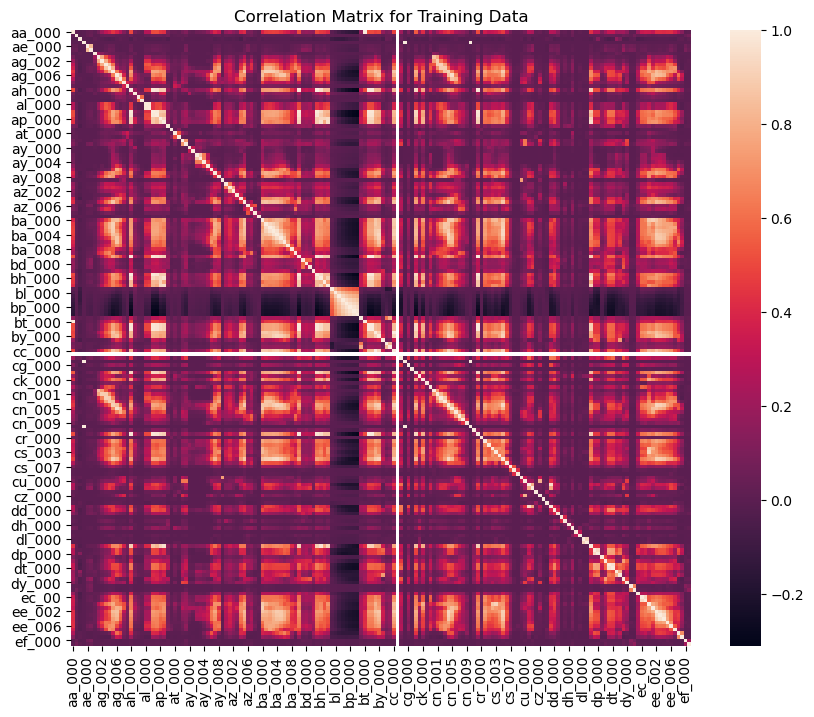

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(APS_all.corr())
plt.title("Correlation Matrix for Training Data")
plt.show()

### iv.
Pick $\lfloor \sqrt{170} \rfloor$ features with highest $CV$, and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [12]:
# Sort CV and obtian top CV indexes
APS_top_cv = APS_cv.sort_values(by=['CV'], ascending=False).head(math.floor(math.sqrt(170)))
top_index = APS_top_cv.index.to_list()
display(APS_top_cv)

,CV
cf_000,20733.593026
co_000,20694.154913
ad_000,20678.680935
cs_009,19249.819432
dj_000,12216.999433
as_000,11389.589918
dh_000,11266.658810
df_000,11127.925843
ag_000,9146.552047
au_000,8609.034659


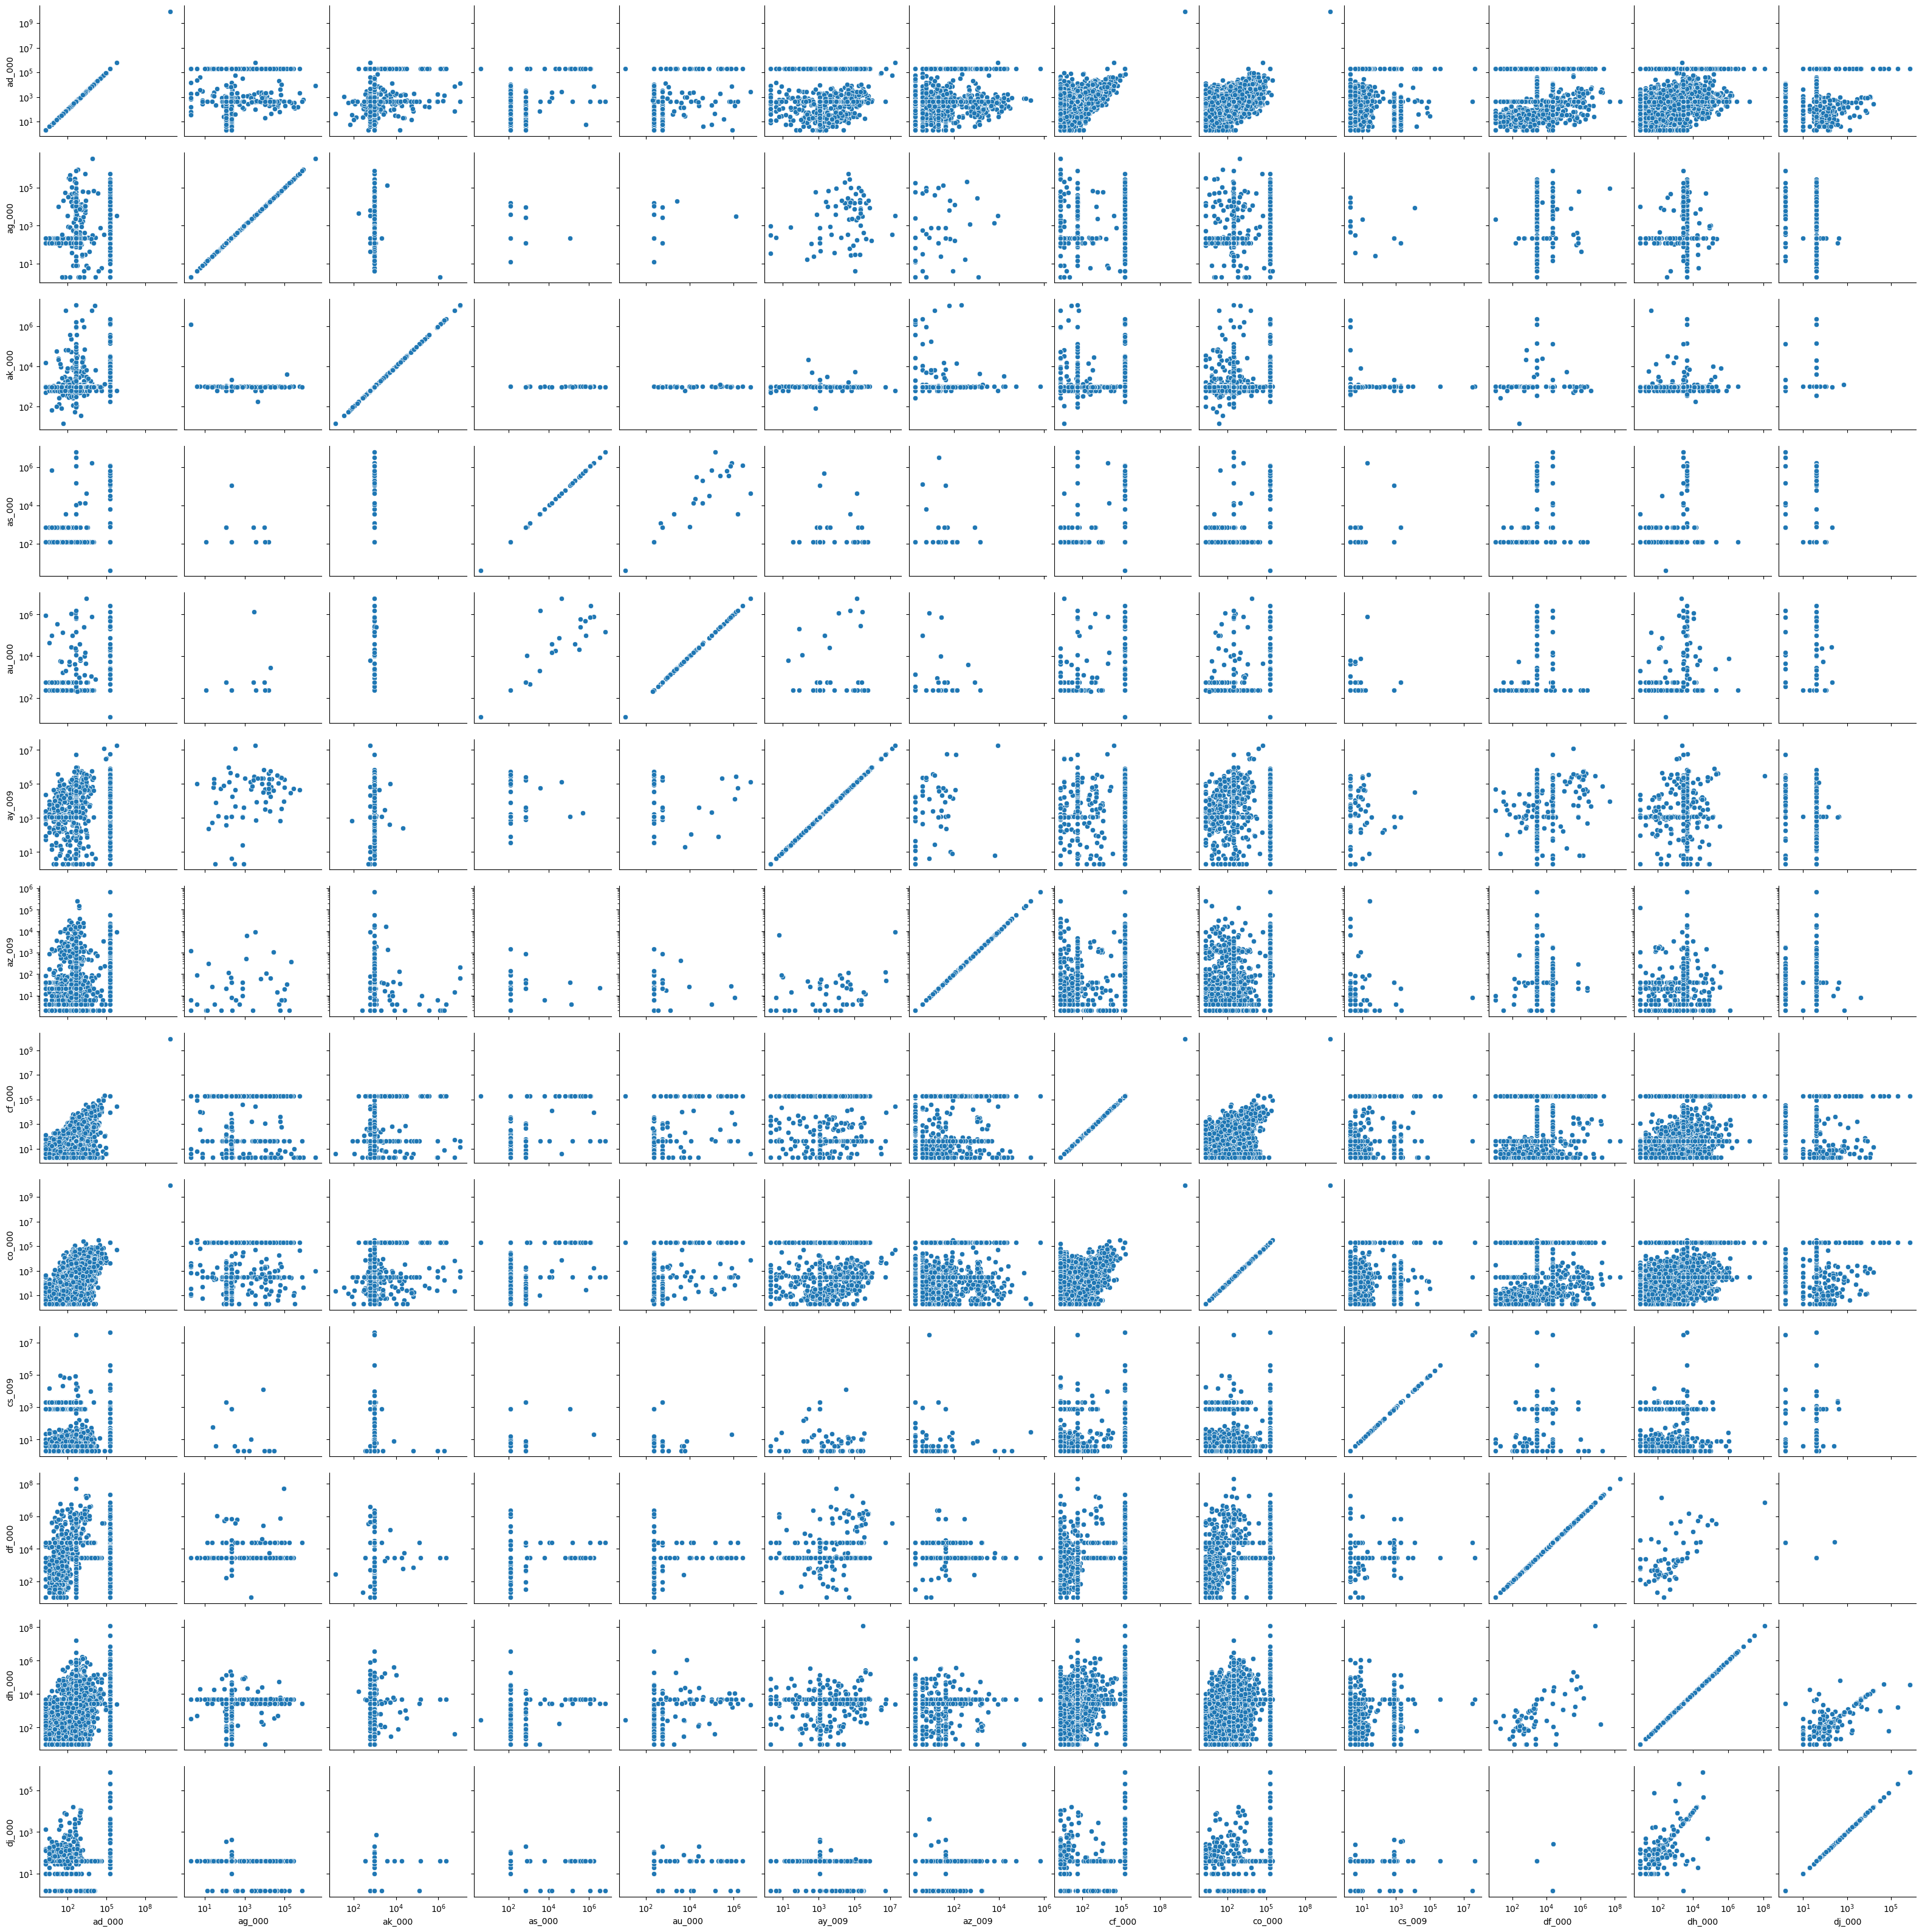

--- 19.310166358947754 seconds ---


In [13]:
# Make scatter plots for top CV features
APS_cv_features = APS_all[APS_all.columns.intersection(top_index)]
# Calculate running time
start_time = time.time()
# sns.pairplot(APS_cv_features)
pairplots = sns.pairplot(APS_cv_features, diag_kind=None)  # Set diagnal to None to save running time
pairplots.set(xscale="log", yscale="log")  # Use log scale for better display result
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

We are hard to draw conclusions based only on the scatter plots. The scatter plots do not help much at this point.

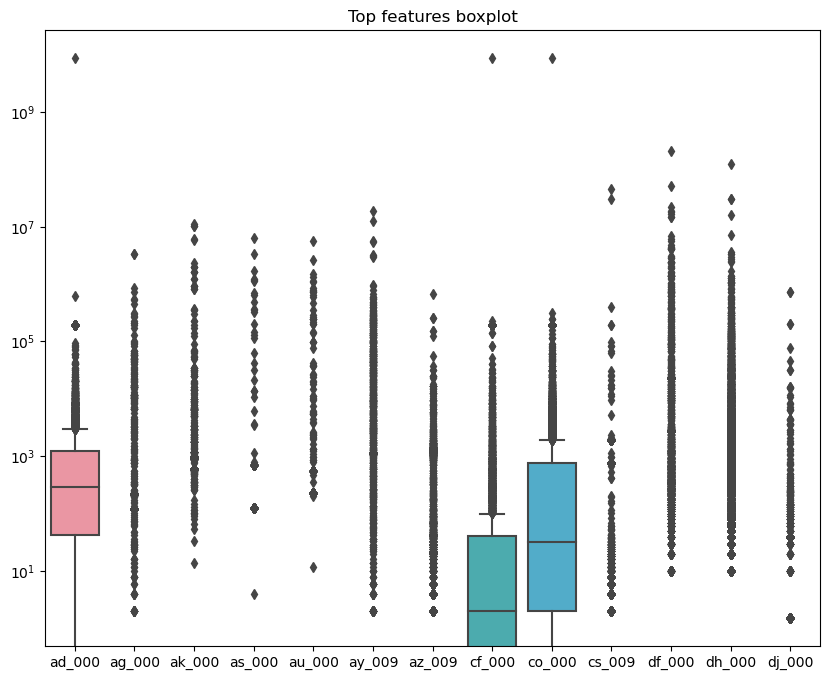

In [14]:
# Make box plots for top CV features
plt.figure(figsize=(10, 8))
boxplots = sns.boxplot(data=APS_cv_features)
boxplots.set(yscale="log")  # Use log scale for better display result
plt.title("Top features boxplot")
plt.show()

### v.
Determine the number of positive and negative data. Is this data set imbalanced?

In [15]:
# Display the number of negative and positive labels in the class column
display(APS_all["class"].value_counts())

neg    74625
pos     1375
Name: class, dtype: int64

We see that we have 74625 negative labels in the training set, while we only have 1375 positive labels. Only 1.8% of labels from the data set is classified as positive samples. This indicates the data set is imbalanced.

## (c) 
Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC
package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [16]:
# Split features and target
X_train = APS_train.iloc[:, 1:]
y_train = APS_train.iloc[:, :1]
X_test = APS_test.iloc[:, 1:]
y_test = APS_test.iloc[:, :1]

In [17]:
# Fit random forest classifier
forest = RandomForestClassifier(oob_score=True)
forest.fit(X_train, y_train.values.ravel())

# Make predictions on training set
y_pred_train = forest.predict(X_train)
# Make predictions on testing set
y_pred_test = forest.predict(X_test)

### Training Set Statistics

[[59000     0]
 [    0  1000]]


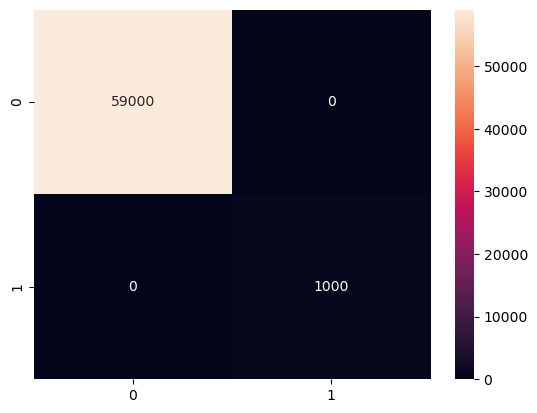

In [18]:
# Calculate confusion matrix for training set
CM = confusion_matrix(y_train, y_pred_train)
print(CM)
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt=".0f")
plt.show()

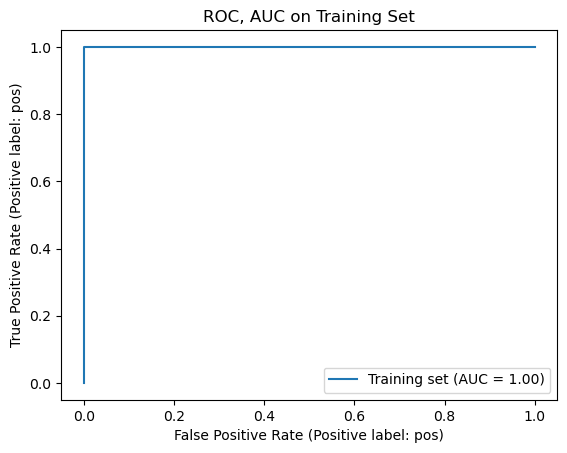

In [19]:
# Plot ROC, AUC for training set
forest_train_disp = RocCurveDisplay.from_estimator(forest, X_train, y_train, name="Training set")
plt.title("ROC, AUC on Training Set")
plt.show()

In [20]:
# Calculate misclassification
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
train_misclassification = (FN + FP) / (TN + FN + TP + FP)
print("Train misclassification:", train_misclassification)

# print(classification_report(y_train, y_pred_train))
# print("Train misclassification:", 1-accuracy_score(y_train, y_pred_train))

Train misclassification: 0.0


### Testing Set

[[15606    19]
 [  102   273]]


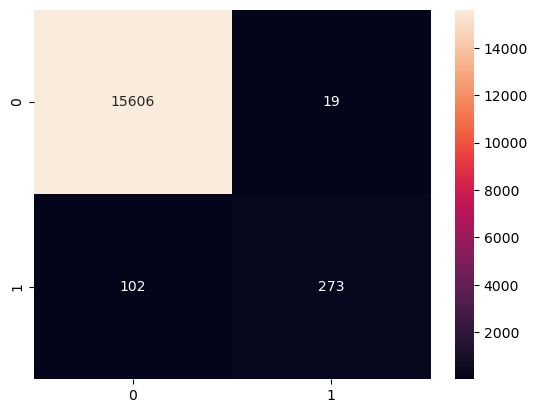

In [21]:
# Calculate confusion matrix for testing set
CM = confusion_matrix(y_test, y_pred_test)
print(CM)
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt=".0f")
plt.show()

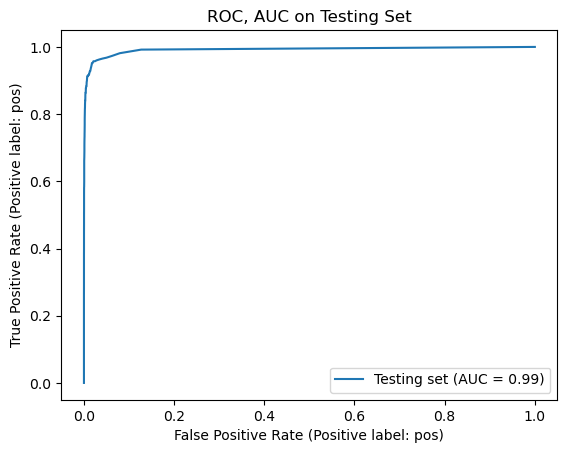

In [22]:
# Plot ROC, AUC for testing set
forest_test_disp = RocCurveDisplay.from_estimator(forest, X_test, y_test, name="Testing set")
plt.title("ROC, AUC on Testing Set")
plt.show()

Indeed, we can plot two ROC, AUC together to compare them.

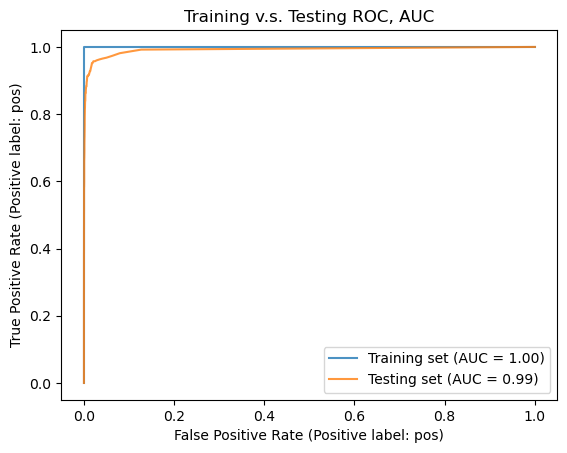

In [23]:
# Plot ROC, AUC for training and testing set
ax = plt.gca()
forest_train_disp.plot(ax=ax, alpha=0.8)
forest_test_disp.plot(ax=ax, alpha=0.8)
plt.title("Training v.s. Testing ROC, AUC")
plt.show()

We observe that the model works better on the training set when comparing to the testing set.

In [24]:
# Calculate misclassification
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
test_misclassification = (FN + FP) / (TN + FN + TP + FP)
print("Test misclassification:", test_misclassification)

# print(classification_report(y_test, y_pred_test))
# print("Test misclassification:", 1-accuracy_score(y_test, y_pred_test))

Test misclassification: 0.0075625


In [25]:
oob_score = forest.oob_score_
print("Out of Bag error:", 1-oob_score)

Out of Bag error: 0.005916666666666681


Compare the Out of Bag error estimate and the test error, we find that Out of Bag error estimate is less than the test error.

## (d)
Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 1c. Compare the results with those of 1c.

After researching online, I found [this article](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/) helpful and decided to adjust `class_weight` parameter in the ranfom forest model.

In [26]:
# Fit random forest classifier compensate for class imbalance
forest_balanced = RandomForestClassifier(oob_score=True, class_weight='balanced')
forest_balanced.fit(X_train, y_train.values.ravel())

# Make predictions on training set
y_pred_train = forest_balanced.predict(X_train)
# Make predictions on testing set
y_pred_test = forest_balanced.predict(X_test)

### Training Set Statistics

[[59000     0]
 [    0  1000]]


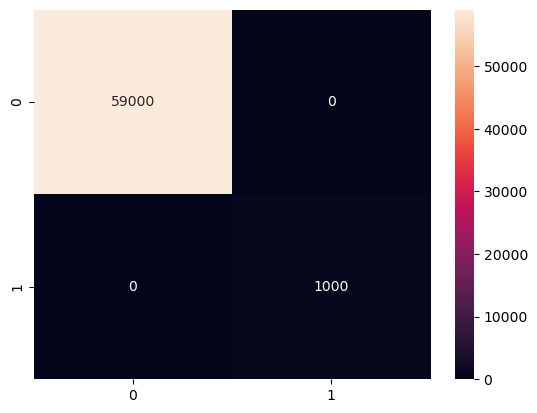

In [27]:
# Calculate confusion matrix for training set
CM = confusion_matrix(y_train, y_pred_train)
print(CM)
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt=".0f")
plt.show()

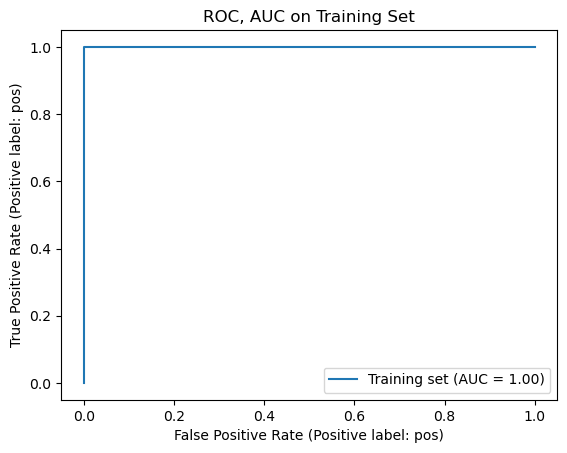

In [28]:
# Plot ROC, AUC for training set
forest_train_disp = RocCurveDisplay.from_estimator(forest_balanced, X_train, y_train, name="Training set")
plt.title("ROC, AUC on Training Set")
plt.show()

In [29]:
# Calculate misclassification
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
train_misclassification = (FN + FP) / (TN + FN + TP + FP)
print("Train misclassification:", train_misclassification)

# print(classification_report(y_train, y_pred_train))
# print("Train misclassification:", 1-accuracy_score(y_train, y_pred_train))

Train misclassification: 0.0


### Testing Set Statistics

[[15613    12]
 [  159   216]]


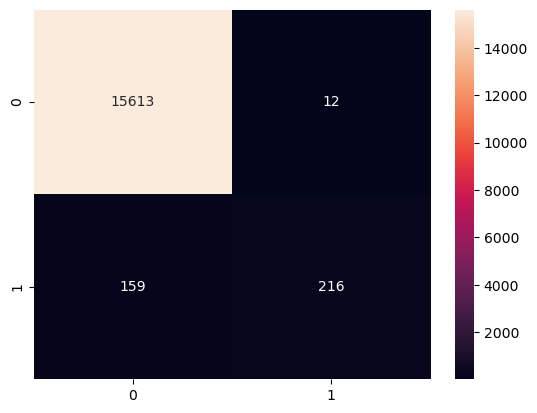

In [30]:
# Calculate confusion matrix for testing set
CM = confusion_matrix(y_test, y_pred_test)
print(CM)
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt=".0f")
plt.show()

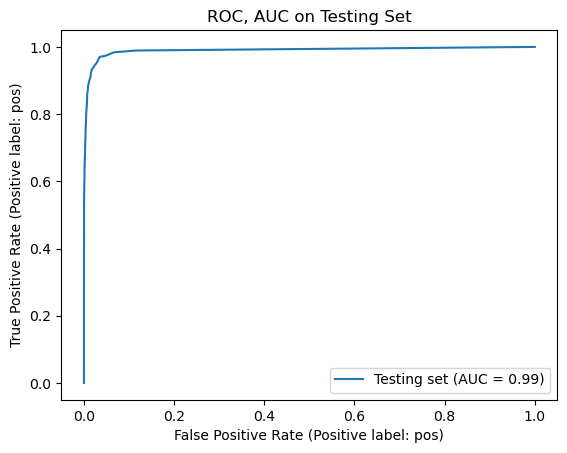

In [31]:
# Plot ROC, AUC for testing set
forest_test_disp = RocCurveDisplay.from_estimator(forest_balanced, X_test, y_test, name="Testing set")
plt.title("ROC, AUC on Testing Set")
plt.show()

Indeed, we can plot two ROC, AUC together to compare them.

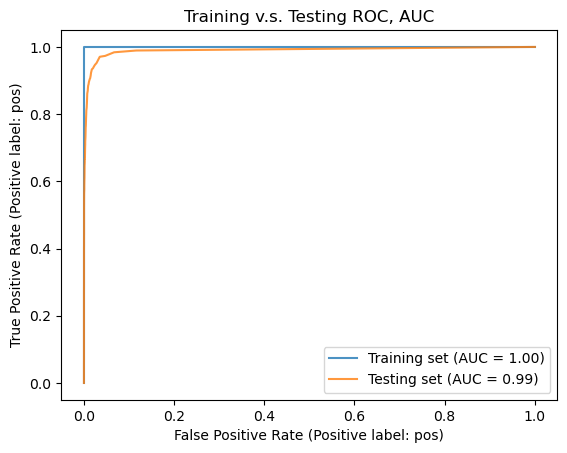

In [32]:
ax = plt.gca()
forest_train_disp.plot(ax=ax, alpha=0.8)
forest_test_disp.plot(ax=ax, alpha=0.8)
plt.title("Training v.s. Testing ROC, AUC")
plt.show()

We observe that the model works better on the training set when comparing to the testing set.

In [33]:
# Calculate misclassification
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
test_misclassification = (FN + FP) / (TN + FN + TP + FP)
print("Test misclassification:", test_misclassification)

# print(classification_report(y_test, y_pred_test))
# print("Test misclassification:", 1-accuracy_score(y_test, y_pred_test))

Test misclassification: 0.0106875


In [34]:
oob_score = forest_balanced.oob_score_
print("Out of Bag error:", 1-oob_score)

Out of Bag error: 0.007499999999999951


The Out of Bag error estimate in this case is less than the test error.

Compare the result of compensating for class imbalance and without compensating it, we find that the model without compensating for class imbalance performs better on the training set.

However, we also see that since the dataset is imbalance, the decision tree is relying on the majority of the class samples to make decisions.

## (e) XGBoost and Model Trees
In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node (i.e. instead of using $X_j > s$ as the decision rule, one has $\sum_j \beta_j X_j > s$. as the decision rule). Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node.

One of the methods that can be used at each node is Logistic Regression. Because the number of variables is large in this problem, one can use L1-penalized logistic regression at each node. You can use XGBoost to fit the model tree. Determine $\alpha$ (the regularization term) using cross-validation. Train the model for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

In [35]:
# Use LabelEncoder to encode data
y_train = LabelEncoder().fit_transform(y_train.values.ravel())
y_test = LabelEncoder().fit_transform(y_test.values.ravel())

In [36]:
# Declare list of lambda values
lambdas = [10**i for i in range(-4, 4)]
print(lambdas)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]


In [37]:
# Initialize list to store MSE result
l1_mse = []
# Calculate running time
start_time = time.time()
for l in lambdas:
    # Set parameters for model
    xgb = XGBClassifier(verbosity=0, reg_lambda=l)
    # Use 10 fold cross validation
    accuracies = cross_val_score(estimator=xgb, X=X_train, y=y_train, cv=10)
    print("Current lambda:", l)
    print("Cross validation score:", accuracies.mean())
    l1_mse.append(accuracies.mean())
    
print("--- %s seconds ---" % (time.time() - start_time))

Current lambda: 0.0001
Cross validation score: 0.9944333333333333
Current lambda: 0.001
Cross validation score: 0.9943833333333332
Current lambda: 0.01
Cross validation score: 0.9945999999999999
Current lambda: 0.1
Cross validation score: 0.9945833333333333
Current lambda: 1
Cross validation score: 0.9947333333333332
Current lambda: 10
Cross validation score: 0.9946333333333334
Current lambda: 100
Cross validation score: 0.9942499999999999
Current lambda: 1000
Cross validation score: 0.9927166666666667
--- 603.9441854953766 seconds ---


In [38]:
# Find the index of best value of lambda
best_lambda_index = np.argmax(l1_mse)
# Refit the model
xgb_refit = XGBClassifier(verbosity=0, reg_lambda=lambdas[best_lambda_index])
xgb_refit.fit(X_train, y_train)
# Make prediction for training and testing data
xgb_refit_train_pred = xgb_refit.predict(X_train)
xgb_refit_test_pred = xgb_refit.predict(X_test)

In [39]:
# Find training error and testing error
print("Train error:", 1-accuracy_score(y_train, xgb_refit_train_pred))
print("Test error:", 1-accuracy_score(y_test, xgb_refit_test_pred))

Train error: 1.666666666666483e-05
Test error: 0.006000000000000005


### Training Set Statistics

[[59000     0]
 [    1   999]]


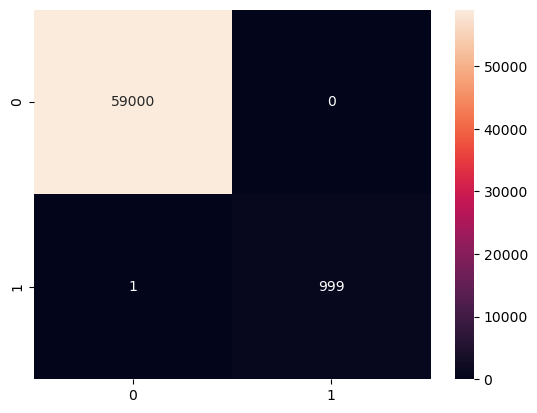

In [40]:
# Calculate confusion matrix for training set
CM = confusion_matrix(y_train, xgb_refit_train_pred)
print(CM)
sns.heatmap(confusion_matrix(y_train, xgb_refit_train_pred), annot=True, fmt=".0f")
plt.show()

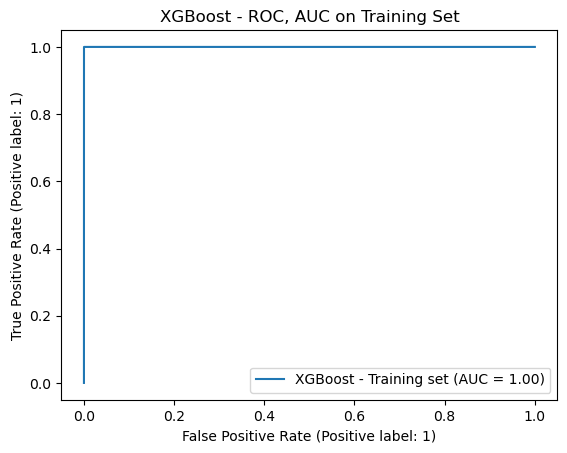

In [41]:
# Plot ROC, AUC for training set
forest_train_disp = RocCurveDisplay.from_estimator(xgb_refit, X_train, y_train, name="XGBoost - Training set")
plt.title("XGBoost - ROC, AUC on Training Set")
plt.show()

### Testing Set

[[15607    18]
 [   78   297]]


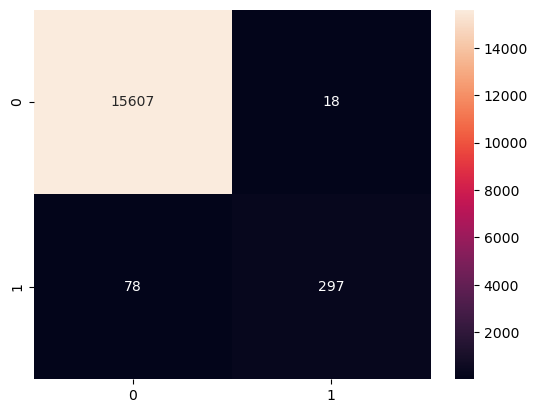

In [42]:
# Calculate confusion matrix for training set
CM = confusion_matrix(y_test, xgb_refit_test_pred)
print(CM)
sns.heatmap(confusion_matrix(y_test, xgb_refit_test_pred), annot=True, fmt=".0f")
plt.show()

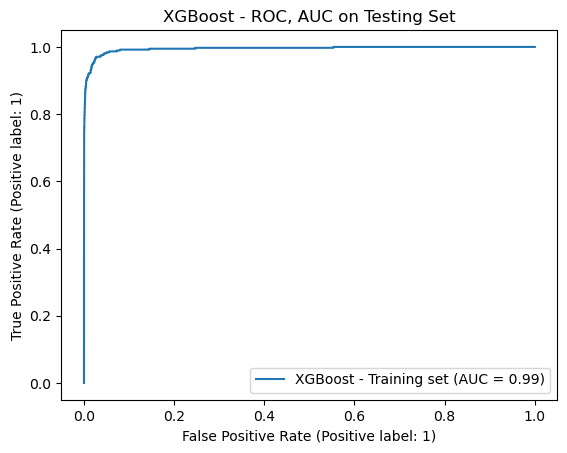

In [43]:
# Plot ROC, AUC for testing set
forest_test_disp = RocCurveDisplay.from_estimator(xgb_refit, X_test, y_test, name="XGBoost - Training set")
plt.title("XGBoost - ROC, AUC on Testing Set")
plt.show()

## (f)
Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance. Train XGBosst with L1-penalized logistic regression at each node using the pre-processed data and repeat 1e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE case.

In [44]:
# Set up pipeline
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=5)],  # Use SMOTE in each iteration
                                ['xgb_model', XGBClassifier(verbosity=0)]])

param_grid = {'xgb_model__reg_alpha': lambdas}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           refit=True,
                           cv=10,)

# Calculate running time
start_time = time.time()
grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print("--- %s seconds ---" % (time.time() - start_time))

Cross-validation score: 0.9903903389830508
Test score: 0.9859435520000001
--- 1377.7039272785187 seconds ---


We we can see from the testing error, the uncompensated case performs better than the SMOTE case. Again, the uncompensated case relys more on the majority of the samples to make decisions, which leads to the result we obtained from training the model.

# 2. ISLR 6.6.3

## (a)
Training RSS.

The training RSS will steadily decrease. This is because we are putting less and less restriction on $\beta_j$'s, so the model will be more and more flexible in the sense that the training RSS steadily decrease.

## (b)
Test RSS.

The test RSS will decrease initially, and then eventually start increasing in a U shape. This is because we increase $s$ from $0$ so that the restriction on the coefficient $\beta_j$ are less than before. Then we see that the model will have more flexibility. This indicates that the test RSS decrease at first. After some point, the test RSS increase again.

## (c)
Variance.

The variance will steadily increase. This is because we are relaxing the restriction on $\beta_j$'s, so the model will include more flexibility. This will lead to higher variance accordingly. Thus, the variance will steadily increase.

## (d)
(Squared) bias.

The squared bias will steadily decrease. Similar to the argument above, we are relaxing the restriction on $\beta_j$'s, so the model will include more flexibility. This will lead to decrease of squared bias.

## (e)
Irreducible error.

The irreducible error remain constant, as we know that the irreducible error does not depend on the model.

# 3. ISLR 6.6.5

## (a)
Write out the ridge regression optimization problem in this setting.

We can write the optimization problem as

$$
(y_1 - \hat{\beta}_1 x_1 - \hat{\beta}_2 x_1)^2 + (y_2 - \hat{\beta}_1 x_2 - \hat{\beta}_2 x_2)^2 + \lambda(\hat{\beta}^2_1+ \hat{\beta}^2_2)
$$

letting $x_{11} = x_{12} = x_1$ and $x_{21} = x_{22} = x_2$.

## (b)
Argue that in this setting, the ridge coefficient estimates satisfy $\hat{\beta}_1 = \hat{\beta}_2$.

We need take partial derivative with respect to $\hat{\beta}_1$ and $\hat{\beta}_2$ and set them equal to 0.

$$
\begin{align*}
\frac{\partial}{\partial \hat{\beta}_1} 
    &= \hat{\beta}_1 (x^2_1 - x^2_1 + \lambda) + \hat{\beta}_2 (x^2_1 + x^2_2) - y_1 x_1 - y_2 x_2 \\
\frac{\partial}{\partial \hat{\beta}_2} 
    &= \hat{\beta}_1 (x^2_1 - x^2_1) + \hat{\beta}_2 (x^2_1 + x^2_2 + \lambda) - y_1 x_1 - y_2 x_2 
\end{align*}
$$

If we set both equal to 0 and move $(- y_1 x_1 - y_2 x_2)$ on the same side, we will see that the equation suggest the result of $\hat{\beta}_1 = \hat{\beta}_2$.

## (c) 
Write out the lasso optimization problem in this setting.

We can use similar settin gas in part (a) such that $x_{11} = x_{12} = x_1$ and $x_{21} = x_{22} = x_2$. Then the optimization problem is that 

$$
(y_1 - \hat{\beta}_1 x_1 - \hat{\beta}_2 x_1)^2 + (y_2 - \hat{\beta}_1 x_2 - \hat{\beta}_2 x_2)^2 + \lambda(|\hat{\beta}_1| + |\hat{\beta}_2|)
$$

## (d)
Argue that in this setting, the lasso coefficients $\hat{\beta}_1$ and $\hat{\beta}_2$ are not unique—in other words, there are many possible solutions to the optimization problem in (c). Describe these solutions.

The solution to the lasso coefficients are not unique given that the constraints of the lasso form like a diamond graph in the plane. If we do a little algebra we should see that we can find solution to the lasso can be find by a line that intersect with the region. This indicates that the solution to lasso is not unique.

# 4. ISLR 8.4.5

If we use the majority vote approach to this problem, we see there are 6 vote for Red and 4 vote for Green. In this situation, Red is the majority, so we classify X as Red.

The average of the probability for class Red from probabilities given in the problem statement is 0.45. In this case, we classify X as Green.

# 5. ISLR 9.7.3

## (a)
We are given n = 7 observations in p = 2 dimensions. For each observation, there is an associated class label.

Sketch the observations.

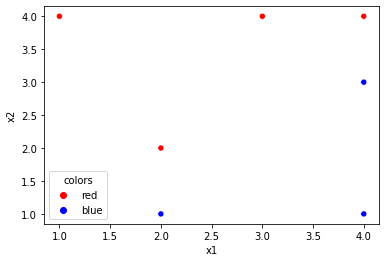

In [20]:
x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
colors = ["red", "red", "red", "red", "blue", "blue", "blue"]
df_obs = pd.DataFrame(dict(x1=x1, x2=x2, colors=colors))
sns.scatterplot(data=df_obs, x='x1', y='x2', hue='colors', palette=['red','blue'])
plt.show()

The observations is sketched above.

## (b)
Sketch the optimal separating hyperplane, and provide the equation for this hyperplane (of the form (9.1)).

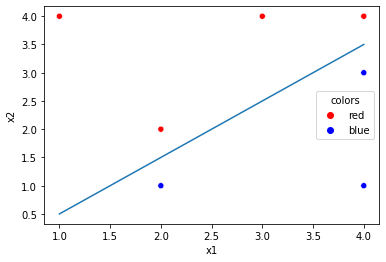

In [21]:
# Add line to seperate the plane
x = [1, 2, 3, 4]
y = [i-0.5 for i in x]
plt.plot(x, y)
sns.scatterplot(data=df_obs, x='x1', y='x2', hue='colors', palette=['red','blue'])
plt.show()

The line given by $x_2 = x_1 - 0.5$ seems be able to separate the hyperplane.

## (c) 
Describe the classification rule for the maximal margin classifier. It should be something along the lines of “Classify to Red if $\beta_0 + \beta_1 X_1 + \beta_2 X_2 > 0$, and classify to Blue otherwise.” Provide the values for $\beta_0$, $\beta_1$, and $\beta_2$.

Let's write the classifier as $f(X) = 0.5 - X_1 + X_2$. We classify to Red if $f(X) > 0$, Blue otherwise.

## (d) 
On your sketch, indicate the margin for the maximal margin hyperplane.

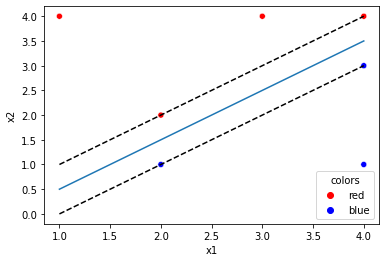

In [28]:
# Add line to seperate the plane
x = [1, 2, 3, 4]
y = [i-0.5 for i in x]
y1 = [i-1 for i in x]
y2 = [i for i in x]
plt.plot(x, y)
plt.plot(x, y1, 'k--')
plt.plot(x, y2, 'k--')
sns.scatterplot(data=df_obs, x='x1', y='x2', hue='colors', palette=['red','blue'])
plt.show()

As shonwn above.

## (e) 
Indicate the support vectors for the maximal margin classifier.

The support vector is Red: $(2, 2)$ and $(4, 4)$ and Blue: $(2, 1)$ and $(4, 3)$.

## (f) 
Argue that a slight movement of the seventh observation would not affect the maximal margin hyperplane.

The senventh observation is not the support vector. When the movement is small, it will not affect the maximal margin hyperplane. However, when the movement is large enough, i.e. the observation move into the margin, it will affect the maximal margin hyperplane.

## (g) 
Sketch a hyperplane that is not the optimal separating hyperplane, and provide the equation for this hyperplane.

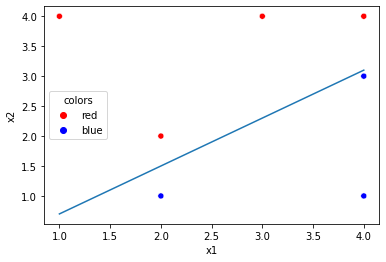

In [44]:
# Add line to seperate the plane
x = [1, 2, 3, 4]
y3 = [0.8*i-0.1 for i in x]
plt.plot(x, y3)
sns.scatterplot(data=df_obs, x='x1', y='x2', hue='colors', palette=['red','blue'])
plt.show()

This will not be an optimal separating hyperplane, which is given by $X_2 = 0.8 \cdot X_1 - 0.1$. Notice the hyperplane still separate the classes.

## (h) 
Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane.

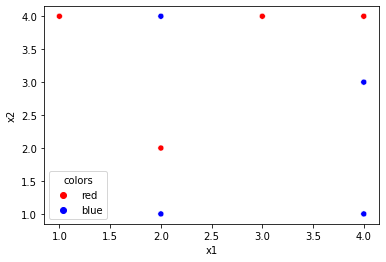

In [45]:
# Add another blue dot
x1 = [3, 2, 4, 1, 2, 4, 4, 2]
x2 = [4, 2, 4, 4, 1, 3, 1, 4]
colors = ["red", "red", "red", "red", "blue", "blue", "blue", "blue"]
df_obs = pd.DataFrame(dict(x1=x1, x2=x2, colors=colors))
sns.scatterplot(data=df_obs, x='x1', y='x2', hue='colors', palette=['red','blue'])
plt.show()

After adding another observation at $(2, 4)$ as Blue, the two classes are no longer separable by a hyperplane.

# Reference

[Bagging and Random Forest for Imbalanced Classification](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/)

[Imbalance Learn Pipeline](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html)

[OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)

[ROC Curve with Visualization API](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_roc_curve_visualization_api.html)

[sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

[sklearn.metrics.RocCurveDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)

[Surviving in a Random Forest with Imbalanced Datasets](https://medium.com/sfu-cspmp/surviving-in-a-random-forest-with-imbalanced-datasets-b98b963d52eb)

[The right way of using SMOTE with Cross-validation](https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7)